# Import Object

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from models import AttentionRNN
from train_model import train_timeseries_net

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [24]:
train_x = pd.read_csv("./data/2_X_train.csv").values
train_y = pd.read_csv("./data/2_Y_train.csv").values.reshape(-1)

sequence_length = 16
num_days = int(train_x.shape[0] / sequence_length)
feature_size = train_x.shape[1]
continuous_feature_size = 8
test_size = 0.1

train_x = train_x.reshape(num_days, sequence_length, feature_size)
train_y = train_y.reshape(num_days, sequence_length, 1)
train_x, test_x, train_y, test_y = train_test_split(train_x,
                                                    train_y,
                                                    test_size=test_size,
                                                    shuffle=True)

train_num_days = int(num_days * (1-test_size))
test_num_days = int(num_days - train_num_days)

train_x = train_x.reshape(train_num_days * sequence_length, feature_size)
test_x = test_x.reshape(test_num_days * sequence_length, feature_size)

ss = preprocessing.StandardScaler()
ss.fit(train_x[:, :continuous_feature_size])
train_x[:, :continuous_feature_size] = \
    ss.transform(train_x[:, :continuous_feature_size])

test_x[:, :continuous_feature_size] = \
    ss.transform(test_x[:, :continuous_feature_size])

train_x = train_x.reshape(train_num_days, sequence_length, feature_size)
test_x = test_x.reshape(test_num_days, sequence_length, feature_size)

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

train_ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=6, shuffle=True)

# Set Free Parameters

In [25]:
input_size = 13
num_layers = 1
hidden_size = 100
num_classes = 1

learning_rate = 0.0005
weight_decay = 1e-3
eps = 1e-11
patience = 10

# Instantiate Model, Criterion, Optimizer

In [26]:
model = AttentionRNN(input_size=input_size, hidden_size=hidden_size,
                     num_layers=num_layers, num_classes=num_classes).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay, eps=eps)

# Training

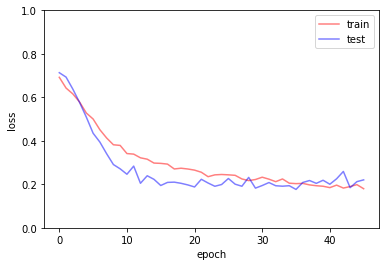

In [27]:
model = train_timeseries_net(model=model, criterion=criterion,
                             optimizer=optimizer, train_loader=train_loader,
                             test_x=test_x, test_y=test_y,
                             device=device, patience=patience)

# Accuracy

In [28]:
model.eval()
score_y = model(test_x, device).reshape(-1)
score_y = torch.sigmoid(score_y)
pred_y = torch.tensor([1 if i > 0.5 else 0 for i in score_y]).to(device)
test_y = test_y.reshape(-1)

print(sum(pred_y == test_y) / int(test_y.shape[0]))

tensor(0.9250, device='cuda:0')


In [29]:
test_y = test_y.to('cpu').detach().numpy().copy()
pred_y = pred_y.to('cpu').detach().numpy().copy()

print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93        90
         1.0       0.86      0.99      0.92        70

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.92       160
weighted avg       0.93      0.93      0.93       160

